### Transfer Learning Task

- 쌀 이파리 병에 대한 분류

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 32
BATCH_SIZE = 64

root = './datasets/rice_leaf_diseases_dataset/original/'

image_data_generator = ImageDataGenerator(rescale=1./255)

generator = image_data_generator.flow_from_directory(
    root,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print(generator.class_indices)

Found 4684 images belonging to 3 classes.
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}


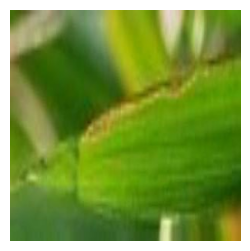

In [2]:
import cv2
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(generator.filepaths[1]), cv2.COLOR_BGR2RGB)

def show_image(image):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.axis('off')

show_image(image)

In [4]:
import pandas as pd

r_df = pd.DataFrame({'file_paths': generator.filepaths, 'targets': generator.classes})
r_df.loc[:, 'file_paths'] = r_df.file_paths.apply(lambda x: x.replace('\\', '/'))
r_df

,file_paths,targets
0,./datasets/rice_leaf_diseases_dataset/original...,0
1,./datasets/rice_leaf_diseases_dataset/original...,0
2,./datasets/rice_leaf_diseases_dataset/original...,0
3,./datasets/rice_leaf_diseases_dataset/original...,0
4,./datasets/rice_leaf_diseases_dataset/original...,0
...,...,...
4679,./datasets/rice_leaf_diseases_dataset/original...,2
4680,./datasets/rice_leaf_diseases_dataset/original...,2
4681,./datasets/rice_leaf_diseases_dataset/original...,2
4682,./datasets/rice_leaf_diseases_dataset/original...,2


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
train_test_split(r_df.file_paths, r_df.targets, stratify=r_df.targets, test_size=0.2, random_state=124)

print(X_train.count())
print(X_test.count())

X_train, X_val, y_train, y_val = \
train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=124)

print(X_train.count())
print(X_val.count())

3747
937
2997
750


In [9]:
import shutil
import os

root = './datasets/rice_leaf_diseases_dataset/'

for file_path in X_train:
    rice_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'train/' + rice_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)
    
for file_path in X_val:
    rice_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'validation/' + rice_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

for file_path in X_test:
    rice_dir = file_path[len(root + 'original/'): file_path.rindex('/')]
    destination = os.path.join(root, 'test/' + rice_dir)

    if not os.path.exists(destination):
        os.makedirs(destination)

    shutil.copy2(file_path, destination)

In [19]:
import albumentations as A

def transform(image):
    aug = A.HorizontalFlip(p=0.5)

    return aug(image=image)['image']

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 32

train_dir = './datasets/rice_leaf_diseases_dataset/train'
validation_dir = './datasets/rice_leaf_diseases_dataset/validation'
test_dir = './datasets/rice_leaf_diseases_dataset/test'

train_data_generator = ImageDataGenerator(preprocessing_function=transform, rescale=1./255)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=8,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_data_generator.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=8,
    class_mode='categorical'
)

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=8,
    class_mode='categorical'
)

print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

Found 2997 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}


In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16

def create_model(verbose=False):
    model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    
    # 분류기 
    x = GlobalAveragePooling2D()(model.output)
    x = Dense(50, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=model.input, outputs=output)
    if verbose:
        model.summary()

    return model

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

mcp_cb = ModelCheckpoint(
    filepath="./callback_files/weights.{epoch:03d}-{val_loss:.4f}-{acc:.4f}.weights.h5",
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    mode='min'
)

ely_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

model = create_model(verbose=True)
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 50)                  │          25,6

 Total params: 14,740,491 (56.23 MB)

 Trainable params: 14,740,491 (56.23 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
import gc

# 불필요한 오브젝트를 지우는 작업
gc.collect()

4061

In [29]:
history = model.fit(train_generator, 
                    batch_size=BATCH_SIZE, epochs=10, 
                    validation_data=validation_generator, 
                    callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 60s 154ms/step - acc: 0.4106 - loss: 1.1658 - val_acc: 0.5520 - val_loss: 0.8475 - learning_rate: 0.0010
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 157ms/step - acc: 0.5876 - loss: 0.8880 - val_acc: 0.3293 - val_loss: 1.0257 - learning_rate: 0.0010
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - acc: 0.4250 - loss: 1.0769 - val_acc: 0.3453 - val_loss: 1.0980 - learning_rate: 0.0010
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 60s 160ms/step - acc: 0.3253 - loss: 1.0984 - val_acc: 0.3453 - val_loss: 1.0979 - learning_rate: 1.0000e-04
Epoch 5/10
180/375 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - acc: 0.3385 - loss: 1.0982

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_generator, batch_size=BATCH_SIZE)

In [ ]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()

show_history(history)